In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def read_input():
    train_x = []
    train_y = []
    with open('input.data') as fp:
        for line in fp:
            train_x.append(float(line.split()[0]))
            train_y.append(float(line.split()[1]))
    return np.array(train_x).reshape(-1,1), np.array(train_y).reshape(-1,1)

### Rational quadratic kernel
$$
k(x_n,x_m)=\sigma^2\bigg(1+\frac{\lVert x_n-x_m\rVert^2}{2\alpha\ell^2}\bigg)^{-\alpha}
$$
With:
* $\sigma^2$ the overall variance
* $\ell$ the lengthscale
* $\alpha$ the scale-mixture ($\alpha$ > 0)

In [3]:
def kernel(xn, xm, k_params):
    
    sigma = k_params[0]
    alpha = k_params[1]
    lengthscale = k_params[2]
    
    dist = cdist(xn, xm, 'sqeuclidean')
    return (sigma**2) * ((1 + dist/(2*alpha*lengthscale**2))**(-alpha))

### Training
$$p({\bf y})\sim N({\bf y}|{\bf 0},{\bf C})$$
$${\bf C}({\bf x}_n,{\bf x}_m)=k({\bf x}_n,{\bf x}_m)+\beta^{-1}\delta_{nm}$$

### Prediction
1. calculate kernel
$$k({\bf x},{\bf x}^*)$$
$$k({\bf x},{\bf x}^*)^T$$
$$k^*=k({\bf x}^*,{\bf x}^*)+\beta^{-1}$$
2. calculate conditional
$$y^*=f({\bf x}^*)$$
$$p(y^*|{\bf y})\sim N(\mu({\bf x}^*),\sigma^2({\bf x}^*))$$
$$\mu({\bf x}^*)=k({\bf x},{\bf x}^*)^T{\bf C}^{-1}{\bf y}$$
$$\sigma^2({\bf x}^*)=k^*-k({\bf x},{\bf x}^*)^T{\bf C}^{-1}k({\bf x},{\bf x}^*)$$

In [4]:
def GP(train_x, train_y, test_x, k_params):
    
    '''
    Training
    '''
    Beta = 5
    I = np.identity(train_x.shape[0])
    C = kernel(train_x, train_x, k_params) + 1/Beta*I
    
    '''
    Prediction
    '''
    kernel_train_test = kernel(train_x, test_x, k_params)
    kernel_test_test = kernel(test_x, test_x, k_params)
    
    C_inv = np.linalg.inv(C)
    mu = (kernel_train_test.T)@C_inv@train_y
    cov = kernel_test_test+1/Beta - (kernel_train_test.T)@C_inv@kernel_train_test
    
    return mu, cov

In [5]:
def visualization(train_x, train_y, test_x, mu, test_y_plus, test_y_minus):
    
    # show all training data point
    plt.plot(train_x, train_y, 'o')
    
    # line to represent mean of f
    plt.plot(test_x, mu, 'k')
    
    # 95% confidence interval of f
    plt.fill_between(test_x.reshape(-1), test_y_plus.reshape(-1), test_y_minus.reshape(-1), facecolor='r', alpha=0.3)
    
    plt.show()

### Optimize the kernel parameters
covariance function ${\bf C}$ with hyper-parameters $\boldsymbol{\theta}$

$${\bf C}_\theta=k_\theta({\bf x}_n,{\bf x}_m)$$

marginal likelihood is function of ${\boldsymbol{\theta}}$

$$p({\bf y}|\theta)\sim N({\bf y}|{\bf 0},{\bf C}_\theta)$$

$$\ln p({\bf y}|\theta)=-\frac{1}{2}\ln|{\bf C}_\theta|-\frac{1}{2}{\bf y}^T{\bf C}^{-1}_\theta{\bf y}-\frac{N}{2}\ln (2\pi)$$

In [6]:
def nmll(k_params, train_x, train_y):
    '''
    negative marginal log-likelihood
    '''
    C = kernel(train_x, train_x, k_params)
    term1 = 0.5 * np.log(np.linalg.det(C))
    term2 = 0.5 * (train_y.T)@np.linalg.inv(C)@train_y
    term3 = (train_x.shape[0]/2.0) * np.log(2*np.pi)
    return (term1 + term2 + term3).item()

Initial kerenel parameters:
sigma=1.0, alpha=1.0, lengthscale=1.0


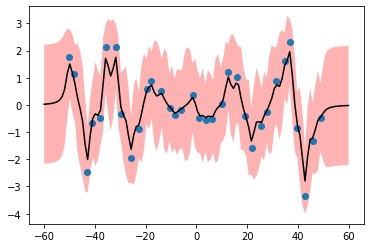

Optimized kerenel parameters:
sigma=1.372307, alpha=8.490846, lengthscale=2.476118


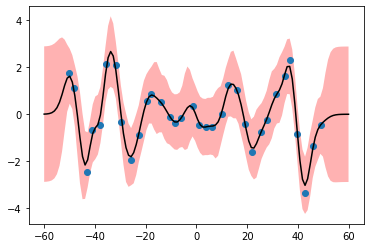

In [7]:
if __name__ == "__main__":
    train_x, train_y = read_input()
    test_x = np.linspace(-60, 60, 120).reshape(-1,1)
    k_params = [1.0, 1.0, 1.0] # initial kernel parameters
    print("Initial kerenel parameters:")
    print("sigma=%.1f, alpha=%.1f, lengthscale=%.1f" % (k_params[0], k_params[1], k_params[2]))
    '''
    Gaussian Process Regression
    '''
    mu, cov = GP(train_x, train_y, test_x, k_params)
    test_y_plus = mu + 2 * (np.diag(np.sqrt(cov)).reshape(-1,1))
    test_y_minus = mu - 2 * (np.diag(np.sqrt(cov)).reshape(-1,1))
    visualization(train_x, train_y, test_x, mu, test_y_plus, test_y_minus)
    
    '''
    Optimize kernel parameters
    '''
    fmin = minimize(fun=nmll, x0=k_params, args=(train_x, train_y))
    print("Optimized kerenel parameters:")
    print("sigma=%f, alpha=%f, lengthscale=%f" % (fmin.x[0], fmin.x[1], fmin.x[2]))
    mu, cov = GP(train_x, train_y, test_x, fmin.x)
    test_y_plus = mu + 2 * (np.diag(np.sqrt(cov)).reshape(-1,1))
    test_y_minus = mu - 2 * (np.diag(np.sqrt(cov)).reshape(-1,1))
    visualization(train_x, train_y, test_x, mu, test_y_plus, test_y_minus)
